# ToBig's_11th_W05_Neural_Network_실습
## Assignment_02 : 2layer MLP 구현
### 11기 김대웅

### Matrix 정리
$ X == (N,D) $  
$ W_1 == (D,H) $  
$ b_1 == (H,) $  
$ H == (N,H) $  
$ A == (N,H) $  
$ W_2 == (H,C) $  
$ b_2 == (C,) $  
$ S == (N,C) $  
$ P == (N,C) $  

### Matrix 미분 정리  
$ H = XW + b\qquad  (N, H) = (N, D) \times (D, H) + (H,) $  
$ L = f(H) $  
$ {\partial L \over \partial W} = X^T {\partial L \over \partial H} = {\partial H \over \partial W} \times {\partial L \over \partial H}$  
$ {\partial L \over \partial X} = {\partial L \over \partial H} W^T = {\partial L \over \partial H} \times {\partial H \over \partial X}$  
$ {\partial L \over \partial b} = 1*{\partial L \over \partial H}  $  

### 2 Layers Chain Rule 정리
$ H = XW_1 + b_1$  
$ A = ReLU(H) $  
$ S = AW_2 + b_2 $  
$ P = Softmax(S) $    
$ L = -LogLikelihood(P) $  
$ {\partial L \over \partial S} = P - T $ : T는 Label  
$ {\partial L \over \partial W_2} = {\partial S \over \partial W_2}{\partial L \over \partial S} = A^T (P-T) $  
$ {\partial L \over \partial b_2} = 1 * {\partial L \over \partial S} = P-T $  
$ {\partial L \over \partial A} = {\partial L \over \partial S}{\partial S \over \partial A} = (P-T)W_2^T $  
$ {\partial L \over \partial H} = (A>0) * {\partial L \over \partial A} $  
$ {\partial L \over \partial W_1} = {\partial H \over \partial W_1}{\partial L \over \partial H} = X^T {\partial L \over \partial H}  $  
$ {\partial L \over \partial b_1} = 1 * {\partial L \over \partial H} = {\partial L \over \partial H} $  

### Softmax - Cross Entropy Error미분  
<img src="img/fig a-5.png">

### 데이터 Load  
cifar-10 데이터를 불러옵니다.  
프레임워크 내 자체적으로 데이터를 로드할 수 있지만, 
이렇게도 데이터 로드가 가능합니다!  
32  32  3 차원의 데이터를 3072 차원으로 바뀌는 것 까지 드릴게요.

In [1]:
from load_cifar_10 import *
import numpy as np
from Model import TwoLayerNet

In [2]:
cifar_10_dir = 'cifar-10-batches-py'

train_data, train_filenames, train_labels, test_data, test_filenames, test_labels, label_names = \
load_cifar_10_data(cifar_10_dir)

In [3]:
train_data.shape

(50000, 32, 32, 3)

In [5]:
def Processing_data(train, test):
    
    #change dtype
    train = np.array(train, dtype=np.float64)
    test = np.array(test, dtype=np.float64)
    

    # Reshaping (50000 X 32 X 32 X 3에서 사진 각각에 대하여만 flatten (1 X 3072))
    train = np.reshape(train, (train.shape[0], -1))
    test = np.reshape(test, (test.shape[0], -1))
    
    # Normalizing # 각 pixel의 평균값을 구함
    mean_image = np.mean(train, axis = 0)

    #print(train.dtype) # Centeralize
    train -= mean_image
    test -= mean_image
    
    return train, test

In [6]:
train_data, test_data = Processing_data(train_data, test_data)

In [7]:
print(train_data.shape)
print(train_labels.shape)
print(test_data.shape)
print(test_labels.shape)

(50000, 3072)
(50000,)
(10000, 3072)
(10000,)


너무 많으니까 5000개, 1000개만 사용합시다!

In [8]:
train_data = train_data[:5000]
train_labels = train_labels[:5000]
test_data = test_data[:1000]
test_labels = test_labels[:1000]

### 데이터 확인  
실제 데이터가 어떻게 생겼는지는 한번 확인해보세요!

In [9]:
import pandas as pd

In [10]:
pd.DataFrame(train_data).head(5)

,0,1,2,3,4,5,6,7,8,9,...,3062,3063,3064,3065,3066,3067,3068,3069,3070,3071
0,-71.71074,-74.05614,-69.5538,-87.14036,-89.44238,-86.85358,-81.05044,-88.24616,-89.58144,-63.56886,...,-9.8778,89.22164,58.30292,26.16942,24.43504,-7.61742,-29.90624,-3.63908,-33.8503,-42.38186
1,23.28926,40.94386,54.4462,-4.14036,1.55762,4.14642,-26.05044,-32.24616,-37.58144,-29.56886,...,22.1222,16.22164,7.30292,25.16942,16.43504,8.38258,28.09376,16.36092,7.1497,29.61814
2,124.28926,118.94386,122.4462,122.85964,117.55762,121.14642,121.94956,116.75384,120.41856,121.43114,...,-34.8778,-48.77836,-40.69708,-30.83058,-47.56496,-40.61742,-30.90624,-46.63908,-39.8503,-30.38186
3,-102.71074,-111.05614,-122.5538,-93.14036,-101.44238,-112.85358,-93.05044,-101.24616,-112.58144,-89.56886,...,-75.8778,-72.77836,-78.69708,-85.83058,-63.56496,-69.61742,-76.90624,-54.63908,-60.8503,-68.38186
4,39.28926,43.94386,65.4462,37.85964,42.55762,64.14642,45.94956,48.75384,70.41856,51.43114,...,-35.8778,-51.77836,-46.69708,-31.83058,-55.56496,-50.61742,-35.90624,-53.63908,-48.8503,-34.38186


### 하이퍼파라미터 설정  
하이퍼파라미터를 설정하겠습니다.  
hidden_size, epoch_size, batch_size, learning_rate 등은 전부 하이퍼 파라미터이니 바꿔서 해보세요.

In [21]:
input_size = 32 * 32 * 3
# Hideen layer의 Node 개수
hidden_size = 50
# Output label
output_size = 10
# 1 epoch : 전체 데이터에 대해 1회 학습
epoch_size = 1000
# 1회 update할 때 쓰일 자료의 크기
batch_size = 100
# 
learning_rate = 0.0001
# 자료 전체의 크기 N
N = train_data.shape[0]

### 모델 만들기  
input_size, hidden_size, output_size는 데이터에 맞게 잘 설정해주세요.

In [22]:
nn = TwoLayerNet(input_size=input_size, hidden_size=hidden_size, output_size=output_size)

In [23]:
history = {'acc': [],'loss': []} #기록해서 그림 그리자!

#코드를 보며 epoch, batch에 대해서 이해해봅시다.
for i in range(epoch_size):
    for j in range(N//batch_size):
        batch_mask = np.random.choice(N, batch_size) #이번 배치에서 쓸 데이터들 인덱스 추출
        x_batch = train_data[batch_mask]
        t_batch = train_labels[batch_mask]
        
        nn.backward(x_batch, t_batch) # 가중치 갱신
    
    #accuracy와 loss를 기록해둡시다.
    history["acc"].append(nn.accuracy(test_data, test_labels))
    history["loss"].append(nn.forward(test_data, test_labels))
    
    if i % 10 == 0:
        print(i, "accuracy :", nn.accuracy(test_data, test_labels))
        print(i, "loss     :", nn.forward(test_data, test_labels))

0 accuracy : 0.116
0 loss     : 2.3025246695631205
10 accuracy : 0.167
10 loss     : 2.3012612855824406
20 accuracy : 0.182
20 loss     : 2.2953004272665543
30 accuracy : 0.177
30 loss     : 2.2743800406795427
40 accuracy : 0.175
40 loss     : 2.225848403609773
50 accuracy : 0.177
50 loss     : 2.1727036638247124
60 accuracy : 0.201
60 loss     : 2.132646830842893
70 accuracy : 0.232
70 loss     : 2.099366618106172
80 accuracy : 0.262
80 loss     : 2.0712907110439245
90 accuracy : 0.261
90 loss     : 2.0469232621022586
100 accuracy : 0.273
100 loss     : 2.0267540321338906
110 accuracy : 0.274
110 loss     : 2.009011649869427
120 accuracy : 0.28
120 loss     : 1.9920076920111833
130 accuracy : 0.285
130 loss     : 1.9754462059046318
140 accuracy : 0.287
140 loss     : 1.9594139118221119
150 accuracy : 0.283
150 loss     : 1.944155176040344
160 accuracy : 0.298
160 loss     : 1.9285331548474633
170 accuracy : 0.304
170 loss     : 1.9136539791470897
180 accuracy : 0.307
180 loss     : 1.

### 그림 그리기

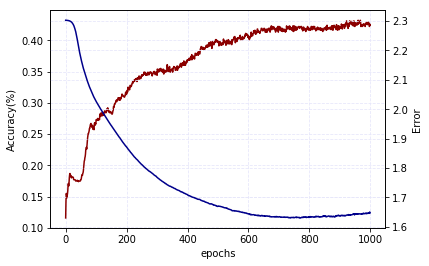

In [24]:
fig = plt.figure()
ax_acc = fig.add_subplot(111)

ax_acc.plot(range(epoch_size), history['acc'], label='정확도(%)', color='darkred')
#plt.text(3, 14.7, "<----------------정확도(%)", verticalalignment='top', horizontalalignment='right')
plt.xlabel('epochs')
plt.ylabel('Accuracy(%)')
ax_acc.grid(linestyle='--', color='lavender')
ax_loss = ax_acc.twinx()
ax_loss.plot(range(epoch_size), history['loss'], label='오차', color='darkblue')
#plt.text(3, 2.2, "<----------------오차", verticalalignment='top', horizontalalignment='left')
plt.ylabel('Error')
ax_loss.yaxis.tick_right()
ax_loss.grid(linestyle='--', color='lavender')

# 그래프 표시
plt.show()